# Rapport projet : exercice 3 Data challenge

Le but de cet exercice est de prédire la sur cote de marée dans deux villes de l’ouest de l’Europe. Il s’agit de la différence entre le niveau de l’océan et le niveau prédit par la marée. Pour cela nous avons à notre disposition deux types de ressources:

- Des mesures de sur cote sur nos deux villes directement.
- Des images de pression atmosphériques qui influence ces surcotes. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Pour les réseaux de neurones
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout

## I. Importation, normalisation et préparation des données

Les données d’images n’étant pas à la même échelle que les surcotes, il est nécessaire de les normaliser en $[-1,1]$. Ensuite, comme nous sommes en grande dimension, il est également nécessaire de réduire la dimension, ce qui aura pour effet d’améliorer l’efficacité des méthodes d’apprentissage statistiques. C’est pourquoi nous appliquons un ACP sur l’ensemble des données. Après plusieurs essais de soumissions et en regardant le cumul de variance expliquée, on s’accorde pour un nombre de composante à hauteur de 170.

In [2]:
X_data_train=np.load('X_train_surge_new.npz')  
slp_train = X_data_train['slp']                        
surge1_train = X_data_train['surge1_input']       
surge2_train = X_data_train['surge2_input']       

X_data_test=np.load('X_test_surge_new.npz')   
slp_test = X_data_test['slp']                         
surge1_test = X_data_test['surge1_input']      
surge2_test = X_data_test['surge2_input']       

In [3]:
# Normalisation [-1 1]

image_train = slp_train.reshape(5599,40*41*41)
image_train -= np.mean(slp_train)
image_train /= 10000 

image_test = slp_test.reshape(509,40*41*41)
image_test -= np.mean(slp_test)
image_test /= 10000 

In [4]:
Y_train = pd.read_csv('Y_train_surge.csv').to_numpy()[:,1:] #on charge les Y_train
X_train=np.concatenate((image_train, surge1_train, surge2_train), axis=1) 
X_test=np.concatenate((image_test, surge1_test, surge2_test), axis=1) 

### I.2 ACP

In [5]:
pca = PCA(n_components = 170) 
pca.fit(np.concatenate((X_train, X_test)))  
X_train_pca = pca.transform(X_train) 
X_test_pca = pca.transform(X_test)

In [6]:
print("Pourcentage de variances expliquées : ",pca.explained_variance_ratio_.cumsum()[-1]*100,"%")

Pourcentage de variances expliquées :  98.88631105422974 %


## Le reseau de neurones

De même, après plusieurs tests, il en résulte que la meilleure combinaison de couche suivie de ces paramètres est la suivante :

- Trois couches du type $Relu$ constitué de 80 neurones
- Une couche tangente hyperbolique $tanh$ avec de même 80 neurones
- Et enfin une regression linéaire comme dernière couche avec 20 neurones
- On utilisera également une méthode de régularisation en incluant des $Dropout$ de 50% pour éviter que des neurones ne prennent trop d'importance. 

On utilisera ensuite une fonction de perte du type $mse$, une métrique $accuracy$ et un optimizer $adam$. Pour fitter ensuite notre modèle, on prendra un $batch size$ standard à 32 et une $epochs$ à 100. La validation split nous permettra de voir la qualité de notre réseau de neurones et de savoir si le modèle choisit génère un surapprentissage. Cette validation va en réalité re diviser notre échantillon en données de test et d'entrainements. Ensuite, le modèle calculera la fonction de perte et la validation test. 

In [13]:
# Initialisation 
regression1=Sequential()

# Ajout de la couche cachée
regression1.add(Dense(units = 80, input_dim = 170,activation="relu"))
regression1.add(Dropout(0.5))
regression1.add(Dense(units = 80,activation="relu"))
regression1.add(Dropout(0.5))
regression1.add(Dense(units = 80,activation="relu"))
regression1.add(Dropout(0.5))
regression1.add(Dense(units = 80,activation="tanh"))

# Ajout de la couche de sortie
regression1.add(Dense(units = 20))

regression1.compile(optimizer = 'adam', loss = 'mse',metrics=['accuracy'])

In [14]:
history1 = regression1.fit(X_train_pca, Y_train, batch_size = 32, epochs = 100,validation_split=0.2)

Epoch 1/100
140/140 [==============================] - 1s 3ms/step - loss: 1.2396 - accuracy: 0.0556 - val_loss: 1.1053 - val_accuracy: 0.0857
Epoch 2/100
140/140 [==============================] - 0s 2ms/step - loss: 0.9517 - accuracy: 0.0623 - val_loss: 0.9710 - val_accuracy: 0.0911
Epoch 3/100
140/140 [==============================] - 0s 2ms/step - loss: 0.8575 - accuracy: 0.0828 - val_loss: 0.8740 - val_accuracy: 0.1161
Epoch 4/100
140/140 [==============================] - 0s 2ms/step - loss: 0.7870 - accuracy: 0.0906 - val_loss: 0.7956 - val_accuracy: 0.1143
Epoch 5/100
140/140 [==============================] - 0s 2ms/step - loss: 0.7383 - accuracy: 0.0991 - val_loss: 0.7380 - val_accuracy: 0.1045
Epoch 6/100
140/140 [==============================] - 0s 2ms/step - loss: 0.7007 - accuracy: 0.0991 - val_loss: 0.7153 - val_accuracy: 0.1107
Epoch 7/100
140/140 [==============================] - 0s 2ms/step - loss: 0.6730 - accuracy: 0.0980 - val_loss: 0.6812 - val_accuracy: 0.0812

Text(0.5, 1.0, 'Fonction de perte et validation test')

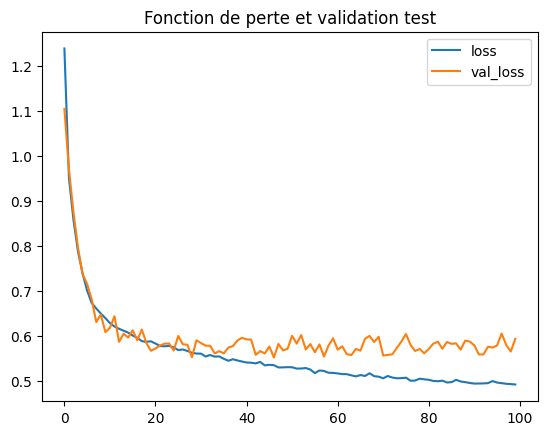

In [15]:
df=pd.DataFrame(data=history1.history)
df=df.drop(["accuracy","val_accuracy"],axis=1)
df.plot()
plt.title("Fonction de perte et validation test")

Comme on peut le voir, la validation split épouse assez bien la courbe de la fonction de perte, qui est elle-même d'ailleurs assez bonne. On peut voir que la courbe de validation se détache et commence à converger au rang 20 alors que la fonction de perte, elle, continue de décroître. Ceci se rapproche d'un bon réseau de neurones. La courbe de validation est un peu bruité mais cela est normal. Dans le rapport, est présent d'autres tests effectués parmi lesquel se trouve un cas de sous-apperntissage et de surappretissage. C'est avec cette structure du reseau de neurones que j'ai atteint mon meilleur score soit 0.51. Passons maintenant aux prédictions.

## III. Prédictions

Pour faire nos prédictions, nous utilisons simplement la fonction $predict$ de sklearn sur nos données test. Nous en faisons un dataframe pour pouvoir mettre en forme pour générer un fichier CSV dans le format indiqué par le site du Data challenge.

In [60]:
pred=regression1.predict(X_test_pca)
pred_surge=pd.DataFrame(pred)

id=pd.DataFrame({"id_sequence":[i for i in range(5600,6109)]})
submission=pd.concat([id,pred_surge],axis=1)

sub=submission.set_index("id_sequence")
y_columns = [f'surge1_t{i}' for i in range(10)] + [f'surge2_t{i}' for i in range(10)]
sub.columns=y_columns
sub

16/16 [==============================] - 0s 1ms/step


,surge1_t0,surge1_t1,surge1_t2,surge1_t3,surge1_t4,surge1_t5,surge1_t6,surge1_t7,surge1_t8,surge1_t9,surge2_t0,surge2_t1,surge2_t2,surge2_t3,surge2_t4,surge2_t5,surge2_t6,surge2_t7,surge2_t8,surge2_t9
id_sequence,,,,,,,,,,,,,,,,,,,,
5600,-0.477919,-0.558271,-0.540618,-0.505278,-0.451570,-0.403403,-0.373015,-0.306388,-0.281100,-0.295319,-0.319120,-0.314716,-0.326768,-0.332775,-0.311419,-0.299124,-0.276476,-0.279475,-0.270869,-0.244107
5601,-0.119073,-0.143279,-0.136325,-0.140804,-0.118343,-0.129587,-0.081067,-0.091661,-0.092199,-0.112492,0.217107,0.222685,0.238635,0.227756,0.228479,0.213689,0.217245,0.161200,0.177035,0.145700
5602,-0.088252,-0.109222,-0.094087,-0.099170,-0.071790,-0.083126,-0.048676,-0.052742,-0.060785,-0.086316,0.089775,0.090070,0.096374,0.088820,0.090990,0.089623,0.093563,0.045926,0.067521,0.040227
5603,0.115899,0.099888,0.053569,0.003163,-0.014461,-0.029410,-0.001980,-0.020933,-0.045685,-0.087569,0.661069,0.691557,0.741196,0.711379,0.712888,0.671312,0.631775,0.570347,0.551659,0.482772
5604,0.070708,0.059940,0.153979,0.207196,0.186915,0.167721,0.171840,0.141353,0.090290,0.039846,-0.372814,-0.387055,-0.401722,-0.397104,-0.379901,-0.361946,-0.339458,-0.352678,-0.317850,-0.326630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6104,-0.350495,-0.385687,-0.395565,-0.396243,-0.362423,-0.323692,-0.252369,-0.232475,-0.206361,-0.255487,0.522564,0.575116,0.590028,0.577162,0.583863,0.520863,0.523305,0.480300,0.458530,0.425308
6105,0.343493,0.303304,0.162831,0.052543,-0.014295,-0.060343,-0.051984,-0.057295,-0.095508,-0.094268,0.662964,0.707935,0.770755,0.735583,0.732444,0.725743,0.651099,0.599858,0.581576,0.495245
6106,-0.233634,-0.264752,-0.307225,-0.341936,-0.328076,-0.288833,-0.247235,-0.219276,-0.200401,-0.250759,0.663608,0.726149,0.751852,0.723254,0.724765,0.672156,0.642912,0.597756,0.572730,0.521953


In [46]:
sub.to_csv("sans_sep_norm-11_Kacp170_u80b32e1003rtanhlin.csv")